In [0]:
"""
Notebook d'étiquetage automatique des fichiers de simulation pour la classification binaire défaut/normal.

Ce notebook parcourt l'ensemble des fichiers de simulation, extrait les informations de défauts
depuis les noms de fichiers, et ajoute une colonne "Defaut" (0/1) indiquant la présence d'anomalie
à chaque instant temporel. Il effectue les opérations suivantes :

1. **Inventaire et visualisation des fichiers par dossier** :
   - Comptage des fichiers CSV dans 13 dossiers de défauts + 1 dossier sans défaut
   - Création de graphiques : diagramme en secteurs (pie chart) et histogramme
   - Liste complète : CC_T, Compresseur, Fuite_Fuel, Noise_TOT, Rec_T, Recuperateur, 
     Turbine, FiltreAir, Mix_Final, et 4 types de Tuyaux
   - Statistiques visuelles pour validation de la répartition des données

2. **Échantillonnage aléatoire pour vérification** :
   - Sélection aléatoire d'un fichier par dossier avec random.choice()
   - Affichage des noms pour vérifier les patterns de nomenclature
   - Traitement séparé du dossier Sans_Defaut_Final
   - Validation de la présence des informations de défaut dans les noms

3. **Configuration du mapping défauts → timestamps** :
   - Dictionnaire fault_mapping associant booléens et temps de début
   - Mappings spécifiques : Foul→SF/SFR, NoiseTOT→StartTOT, eta_comp→start_comp_eff
   - Gestion des cas spéciaux : FiltreAir (SF), Recuperateur (SFR)
   - Support des défauts multiples (Tuyaux avec 4 booléens/starts)

4. **Étiquetage automatique avec fonction extract_active_start()** :
   - Extraction des booléens actifs (=1) depuis les noms de fichiers
   - Récupération des timestamps de début correspondants
   - Cas spécial Defaut_Mix : recherche pattern S[A-Z]+_(\d+)
   - Cas Tuyaux : gestion des 4 fuites possibles simultanément
   - Ajout colonne "Defaut" : 0 avant timestamp, 1 après
   - Sauvegarde dans dossier centralisé : fichiers_etiquettes_defaut/

5. **Vérification exhaustive de l'étiquetage** :
   - Lecture de tous les fichiers étiquetés et validation
   - Comparaison Time du premier Defaut=1 vs timestamp extrait
   - Tolérance de 0.5s pour les erreurs d'arrondi
   - Vérification spécifique pour Defaut_Fuite_Fuel (StartFuel)
   - Rapport détaillé : OK/MISMATCH avec liste des anomalies

6. **Nettoyage et analyses finales** :
   - Suppression pattern "NoiseTOT_0_StartTOT_0_" dans Fuite_Fuel
   - Visualisation exemple : graphique temporel du signal Defaut
   - Statistiques globales : pie chart fichiers avec/sans défaut
   - Tableau récapitulatif par dossier : nombre avec/sans défaut
   - Correction bug FiltreAir : traitement spécifique Foul→SF

Paramètres et chemins :
- BASE_DIR : /Volumes/dbe_dbx_internships/justin/predictive_maintenance/
- DOSSIER_SORTIE : fichiers_etiquettes_defaut/ (créé automatiquement)
- Format sortie : {Dossier}__{Fichier_Original}.csv
- Colonne ajoutée : "Defaut" (0=normal, 1=anomalie)

Mappings défauts principaux :
- FiltreAir : Foul_1 → SF_XXX
- Recuperateur : Foul_1 → SFR_XXX  
- Noise : NoiseTOT_1 → StartTOT_XXX, NoiseFuel_1 → StartFuel_XXX
- Compresseur : bool_eta_comp_deg_1 → start_comp_eff_XXX
- Turbine : bool_eta_turb_1 → start_XXX
- Mix : min(S[A-Z]+_XXX) où XXX > 0
- Tuyaux : boolFuites_X_X_X_X → startFuites_XXX_XXX_XXX_XXX

Résultats produits :
- Colonne Defaut binaire pour classification supervisée
- Vérification : 0 mismatch attendu (sauf erreurs données)

"""

In [0]:
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt

In [0]:
BASE_DIR = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/"
DOSSIER_SORTIE = os.path.join(BASE_DIR, "fichiers_etiquettes_defaut")
os.makedirs(DOSSIER_SORTIE, exist_ok=True)

In [0]:
DOSSIERS = [
    "Defaut_CC_T",
    "Defaut_Compresseur",
    "Defaut_Fuite_Fuel",
    "Defaut_Noise_TOT",
    "Defaut_Rec_T",
    "Defaut_Recuperateur",
    "Defaut_Turbine",
    "FiltreAir",
    "Defaut_Mix_Final",
    "Defaut_Tuyaux_cc_t",
    "Defaut_Tuyaux_comp_rec",
    "Defaut_Tuyaux_rec_cc",
    "Defaut_Tuyaux_turb_rec"
]

DOSSIER_SANS_DEFAUT = "Dossier_Sans_Defaut_Final"

1. Affichage du nombre de fichiers csv par dossier de défauts

In [0]:
print("\n=== NOMBRE DE FICHIERS CSV PAR DOSSIER ===\n")

ALL_DOSSIERS = DOSSIERS + [DOSSIER_SANS_DEFAUT]

for dossier in ALL_DOSSIERS:
    path_dossier = os.path.join(BASE_DIR, dossier)
    if os.path.isdir(path_dossier):
        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
        print(f"{dossier} : {len(fichiers_csv)} fichiers CSV")
    else:
        print(f"{dossier} : [DOSSIER INEXISTANT]")

print("\n=== FIN ===")



=== NOMBRE DE FICHIERS CSV PAR DOSSIER ===

Defaut_CC_T : 101 fichiers CSV
Defaut_Compresseur : 100 fichiers CSV
Defaut_Fuite_Fuel : 99 fichiers CSV
Defaut_Noise_TOT : 98 fichiers CSV
Defaut_Rec_T : 100 fichiers CSV
Defaut_Recuperateur : 100 fichiers CSV
Defaut_Turbine : 96 fichiers CSV
FiltreAir : 100 fichiers CSV
Defaut_Mix_Final : 1072 fichiers CSV
Defaut_Tuyaux_cc_t : 98 fichiers CSV
Defaut_Tuyaux_comp_rec : 100 fichiers CSV
Defaut_Tuyaux_rec_cc : 97 fichiers CSV
Defaut_Tuyaux_turb_rec : 100 fichiers CSV
Dossier_Sans_Defaut_Final : 3291 fichiers CSV

=== FIN ===


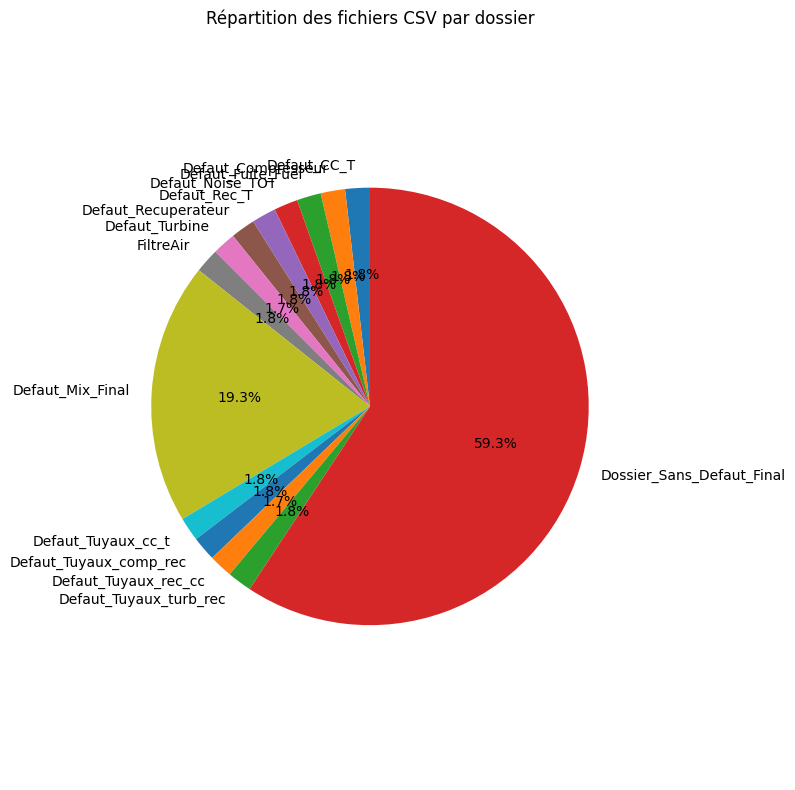

In [0]:
import matplotlib.pyplot as plt

dossier_counts = {}

for dossier in ALL_DOSSIERS:
    path_dossier = os.path.join(BASE_DIR, dossier)
    if os.path.isdir(path_dossier):
        fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
        dossier_counts[dossier] = len(fichiers_csv)
    else:
        dossier_counts[dossier] = 0

labels = list(dossier_counts.keys())
sizes = list(dossier_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des fichiers CSV par dossier")
plt.axis('equal')
plt.tight_layout()
plt.show()


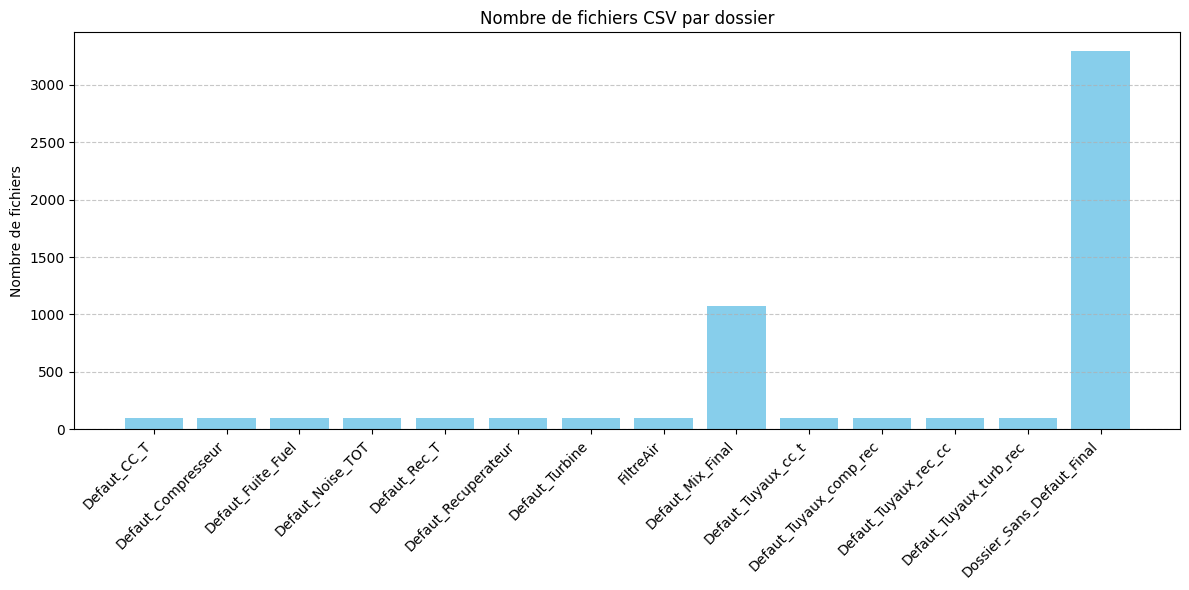

In [0]:
plt.figure(figsize=(12, 6))
plt.bar(dossier_counts.keys(), dossier_counts.values(), color='skyblue')
plt.title("Nombre de fichiers CSV par dossier")
plt.ylabel("Nombre de fichiers")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


2. Affichage d'un fichier de simulation par dossier de défauts

In [0]:
print("\n=== AFFICHAGE EXEMPLE DE FICHIER PAR DOSSIER ===\n")

for dossier in DOSSIERS:
    path_dossier = os.path.join(BASE_DIR, dossier)
    if not os.path.isdir(path_dossier):
        print(f"[IGNORÉ] Dossier inexistant : {path_dossier}")
        continue

    fichiers_csv = [f for f in os.listdir(path_dossier) if f.endswith(".csv")]
    if not fichiers_csv:
        print(f"{dossier} : Aucun fichier CSV trouvé.\n")
        continue

    fichier_exemple = random.choice(fichiers_csv)
    print(f"{dossier} → Exemple : {fichier_exemple}\n")

print("=== FIN ===")



=== AFFICHAGE EXEMPLE DE FICHIER PAR DOSSIER ===

Defaut_CC_T → Exemple : Sim_12_N_70.04_TOT_623.21_Tamb_286.81_pamb_1.01_perc_fool_CC2T_0.012214_bool_foul_CC_turb_1_start_foul_CC_turb_1099_T_c_out_init_324.2084_T_t_out_init_528.1709_TIT_init_599.5050.csv

Defaut_Compresseur → Exemple : Sim_1_N_92.59_TOT_681.16_Tamb_269.50_pamb_0.98_ slope_degradation_0.00002_start_comp_eff_557_bool_eta_comp_deg_1_T_c_out_init_382.4389_T_t_out_init_912.1969_TIT_init_1097.4752.csv

Defaut_Fuite_Fuel → Exemple : Sim_31_N_83.90_TOT_676.80_Tamb_310.34_pamb_1.00_CoefDrift_-0.07270_Kleak_0.00061_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_1293.csv

Defaut_Noise_TOT → Exemple : Sim_14_N_99.85_TOT_515.64_Tamb_285.28_pamb_1.03_CoefDrift_-0.08986_Kleak_0.00119_NoiseTOT_1_StartTOT_1635_NoiseFuel_0_StartFuel_0.csv

Defaut_Rec_T → Exemple : Sim_24_N_75.59_TOT_548.34_Tamb_283.35_pamb_0.92_perc_fool_T2REC_0.0098785_bool_foul_recup_turb_1_start_foul_T_REC_1913_T_c_out_init_293.9367_T_t_out_init_349.8804_TIT_init_369.

3. Affichage d'un fichier de simulation du dossier Sans_Defaut

In [0]:
print("\n=== EXEMPLE POUR DOSSIER SANS DÉFAUT ===\n")

path_dossier_sans_defaut = os.path.join(BASE_DIR, DOSSIER_SANS_DEFAUT)
if not os.path.isdir(path_dossier_sans_defaut):
    print(f"[ERREUR] Dossier inexistant : {path_dossier_sans_defaut}")
else:
    fichiers_csv = [f for f in os.listdir(path_dossier_sans_defaut) if f.endswith(".csv")]
    if not fichiers_csv:
        print(f"{DOSSIER_SANS_DEFAUT} : Aucun fichier CSV trouvé.\n")
    else:
        fichier_exemple = random.choice(fichiers_csv)
        print(f"{DOSSIER_SANS_DEFAUT} → Exemple : {fichier_exemple}\n")

print("=== FIN ===")



=== EXEMPLE POUR DOSSIER SANS DÉFAUT ===

Dossier_Sans_Defaut_Final → Exemple : Sim_586_N_77.6364_TOT_638.2378_Tamb_276.2189_pamb_0.96_percAsh_0.0001086_Foul_0_SF_0.csv

=== FIN ===


4. Etiquettage des dossiers avec/sans défauts

In [0]:
fault_mapping = {
    "Foul": "SF",  # pour FiltreAir : booléen -> temps de début du défaut
    "Foul": "SFR",  # pour Defaut_Recuperateur
    "NoiseTOT": "StartTOT",
    "NoiseFuel": "StartFuel",
    "bool_eta_comp_deg": "start_comp_eff",
    "bool_eta_turb": "start",
    "bool_foul_CC_turb": "start_foul_CC_turb",
    "bool_foul_recup_turb": "start_foul_T_REC"
}

In [0]:
def extract_active_start(filename, dossier):
    starts = []

    if dossier not in ["Defaut_Mix_Final"]:  # Cas classique -> utiliser le fault_mapping
        for bool_key, start_key in fault_mapping.items():
            bool_match = re.search(f"{bool_key}_(\d)", filename)
            if bool_match and bool_match.group(1) == "1":
                start_match = re.search(f"{start_key}_?(\d+)", filename)
                if start_match:
                    starts.append(int(start_match.group(1)))

        fuite_bool_match = re.search(r"boolFuites_(\d)_(\d)_(\d)_(\d)", filename) # Cas fuites multiples (Tuyaux)
        fuite_start_match = re.search(r"startFuites_(\d+)_(\d+)_(\d+)_(\d+)", filename)
        if fuite_bool_match and fuite_start_match:
            bools = list(map(int, fuite_bool_match.groups()))
            starts_all = list(map(int, fuite_start_match.groups()))
            starts += [s for b, s in zip(bools, starts_all) if b == 1]

    elif dossier == "Defaut_Mix_Final": # Cas Defaut Mix
        s_matches = re.findall(r"S[A-Z]+_(\d+)", filename)
        s_values = [int(val) for val in s_matches if int(val) > 0]
        if s_values:
            starts.append(min(s_values))

    return min(starts) if starts else None


def traiter_dossier(dossier, avec_defaut=True):
    dossier_complet = os.path.join(BASE_DIR, dossier)
    fichiers = [f for f in os.listdir(dossier_complet) if f.endswith(".csv")]

    for fichier in fichiers:
        chemin_fichier = os.path.join(dossier_complet, fichier)
        try:
            df = pd.read_csv(chemin_fichier)
        except Exception as e:
            print(f"[ERREUR LECTURE] {fichier} : {e}")
            continue

        df["Defaut"] = 0

        if avec_defaut:
            start_defaut = extract_active_start(fichier, dossier)
            if start_defaut is not None:
                df.loc[df["Time"] >= start_defaut, "Defaut"] = 1

        nom_sortie = f"{dossier}__{fichier}"
        chemin_sortie = os.path.join(DOSSIER_SORTIE, nom_sortie)

        try:
            df.to_csv(chemin_sortie, index=False)
            statut = "avec défaut" if df["Defaut"].sum() > 0 else "sans défaut"
            print(f"[OK] {nom_sortie} : {statut}")
        except Exception as e:
            print(f"[ERREUR SAUVEGARDE] {nom_sortie} : {e}")

print("\n=== Traitement des dossiers avec défauts ===")
for dossier_defaut in DOSSIERS :
    traiter_dossier(dossier_defaut, avec_defaut=True)

print("\n=== Traitement du dossier sans défaut ===")
traiter_dossier(DOSSIER_SANS_DEFAUT, avec_defaut=False)

print("\n Tous les fichiers ont été étiquetés et enregistrés dans :", DOSSIER_SORTIE)

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
/root/.ipykernel/16547/command-6811636406426048-673140420:20: SyntaxWarning: invalid escape sequence '\d'
  bool_match = re.search(f"{bool_key}_(\d)", filename)
/root/.ipykernel/16547/command-6811636406426048-673140420:22: SyntaxWarning: invalid escape sequence '\d'
  start_match = re.search(f"{start_key}_?(\d+)", filename)



=== Traitement des dossiers avec défauts ===
[OK] Defaut_CC_T__Sim_100_N_72.05_TOT_559.11_Tamb_279.80_pamb_0.99_perc_fool_CC2T_0.008182_bool_foul_CC_turb_1_start_foul_CC_turb_1685_T_c_out_init_332.7405_T_t_out_init_603.6400_TIT_init_698.3848.csv : avec défaut
[OK] Defaut_CC_T__Sim_101_N_82.36_TOT_670.82_Tamb_280.54_pamb_0.91_perc_fool_CC2T_0.009275_bool_foul_CC_turb_1_start_foul_CC_turb_1326_T_c_out_init_330.7693_T_t_out_init_589.4647_TIT_init_679.9412.csv : avec défaut
[OK] Defaut_CC_T__Sim_10_N_87.96_TOT_678.18_Tamb_311.11_pamb_0.92_perc_fool_CC2T_0.009075_bool_foul_CC_turb_1_start_foul_CC_turb_515_T_c_out_init_356.0056_T_t_out_init_673.3906_TIT_init_784.3933.csv : avec défaut
[OK] Defaut_CC_T__Sim_11_N_93.63_TOT_550.86_Tamb_303.86_pamb_1.02_perc_fool_CC2T_0.010520_bool_foul_CC_turb_1_start_foul_CC_turb_393_T_c_out_init_325.6076_T_t_out_init_466.8520_TIT_init_516.2511.csv : avec défaut
[OK] Defaut_CC_T__Sim_12_N_70.04_TOT_623.21_Tamb_286.81_pamb_1.01_perc_fool_CC2T_0.012214_bool_fou

5. Vérification de la procédure d'étiquetage

In [0]:
print("\n=== VERIFICATION DE TOUS LES FICHIERS ETIQUETES (PAR TOUTES LES CLES DEFAUTS) ===\n")

fichiers_etiquetes = [f for f in os.listdir(DOSSIER_SORTIE) if f.endswith(".csv")]

nb_checked = 0
nb_mismatch = 0
liste_mismatch = []  

for fichier_test in fichiers_etiquetes:
    chemin_test = os.path.join(DOSSIER_SORTIE, fichier_test)
    df_test = pd.read_csv(chemin_test).dropna()

    nom_dossier = fichier_test.split("__")[0]

    if (df_test["Defaut"] == 1).any():
        index_defaut = df_test[df_test["Defaut"] == 1].index[0]
        time_start = df_test.loc[index_defaut, "Time"]

        mismatch = False
        sf = None

        if nom_dossier == "Defaut_Mix_Final":
            s_matches = re.findall(r"S[A-Z]+_(\d+)", fichier_test)
            s_values = [int(val) for val in s_matches if int(val) > 0]
            if s_values:
                sf = min(s_values)
                if abs(time_start - sf) > 0.5:
                    mismatch = True

        elif "Tuyaux" in nom_dossier:
            fuite_match = re.search(r"startFuites_(\d+)_(\d+)_(\d+)_(\d+)", fichier_test)
            if fuite_match:
                starts_all = list(map(int, fuite_match.groups()))
                starts_active = [s for s in starts_all if s > 0]
                if starts_active:
                    sf = min(starts_active)
                    if abs(time_start - sf) > 0.5:
                        mismatch = True

        else:
            for key, start_key in fault_mapping.items():
                match = re.search(f"{start_key}_?(\d+)", fichier_test)
                if match:
                    sf = int(match.group(1))
                    if abs(time_start - sf) > 0.5:
                        mismatch = True
                    break  

        if mismatch:
            print(f"[MISMATCH] {fichier_test} → Time = {time_start:.2f} vs Start = {sf}")
            nb_mismatch += 1
            liste_mismatch.append(fichier_test)  
        else:
            print(f"[OK] {fichier_test} → Time = {time_start:.2f} vs Start = {sf}")

    else:
        print(f"[NO DEFECT] {fichier_test}")

    nb_checked += 1

print(f"\n=== VERIFICATION COMPLETE ===")
print(f"Total fichiers vérifiés : {nb_checked}")
print(f"Fichiers avec mismatch : {nb_mismatch}")

if liste_mismatch:
    print("\nListe des fichiers en mismatch :")
    for fichier in liste_mismatch:
        print(f"- {fichier}")
else:
    print("\nAucun mismatch trouvé !")

print("=== FIN ===")


<>:45: SyntaxWarning: invalid escape sequence '\d'
<>:45: SyntaxWarning: invalid escape sequence '\d'
/root/.ipykernel/4803/command-6811636406426050-3156479542:45: SyntaxWarning: invalid escape sequence '\d'
  match = re.search(f"{start_key}_?(\d+)", fichier_test)



=== VERIFICATION DE TOUS LES FICHIERS ETIQUETES (PAR TOUTES LES CLES DEFAUTS) ===

[OK] Defaut_CC_T__Sim_100_N_72.05_TOT_559.11_Tamb_279.80_pamb_0.99_perc_fool_CC2T_0.008182_bool_foul_CC_turb_1_start_foul_CC_turb_1685_T_c_out_init_332.7405_T_t_out_init_603.6400_TIT_init_698.3848.csv → Time = 1685.00 vs Start = 1685
[OK] Defaut_CC_T__Sim_101_N_82.36_TOT_670.82_Tamb_280.54_pamb_0.91_perc_fool_CC2T_0.009275_bool_foul_CC_turb_1_start_foul_CC_turb_1326_T_c_out_init_330.7693_T_t_out_init_589.4647_TIT_init_679.9412.csv → Time = 1326.00 vs Start = 1326
[OK] Defaut_CC_T__Sim_10_N_87.96_TOT_678.18_Tamb_311.11_pamb_0.92_perc_fool_CC2T_0.009075_bool_foul_CC_turb_1_start_foul_CC_turb_515_T_c_out_init_356.0056_T_t_out_init_673.3906_TIT_init_784.3933.csv → Time = 515.00 vs Start = 515
[OK] Defaut_CC_T__Sim_11_N_93.63_TOT_550.86_Tamb_303.86_pamb_1.02_perc_fool_CC2T_0.010520_bool_foul_CC_turb_1_start_foul_CC_turb_393_T_c_out_init_325.6076_T_t_out_init_466.8520_TIT_init_516.2511.csv → Time = 393.00 vs 

In [0]:
print("\n=== VERIFICATION SPECIFIQUE POUR Defaut_Fuite_Fuel ===\n")

fichiers_fuel = [f for f in os.listdir(DOSSIER_SORTIE) if f.startswith("Defaut_Fuite_Fuel__") and f.endswith(".csv")]

nb_checked = 0
nb_mismatch = 0
liste_mismatch = []

for fichier_test in fichiers_fuel:
    chemin_test = os.path.join(DOSSIER_SORTIE, fichier_test)
    df_test = pd.read_csv(chemin_test).dropna()

    if (df_test["Defaut"] == 1).any():
        index_defaut = df_test[df_test["Defaut"] == 1].index[0]
        time_start = df_test.loc[index_defaut, "Time"]

        match = re.search(r"StartFuel_?(\d+)", fichier_test) # On ne cherche QUE StartFuel
        if match:
            sf = int(match.group(1))
            mismatch = False

            if abs(time_start - sf) > 0.5:
                mismatch = True

            if mismatch:
                print(f"[MISMATCH] {fichier_test} → Time = {time_start:.2f} vs StartFuel = {sf}")
                nb_mismatch += 1
                liste_mismatch.append(fichier_test)
            else:
                print(f"[OK] {fichier_test} → Time = {time_start:.2f} vs StartFuel = {sf}")
        else:
            print(f"[ERREUR] Pas de StartFuel trouvé dans le nom de fichier : {fichier_test}")

    else:
        print(f"[NO DEFECT] {fichier_test}")

    nb_checked += 1

print(f"\n=== VERIFICATION FINALE Fuite Fuel ===")
print(f"Total fichiers vérifiés : {nb_checked}")
print(f"Fichiers avec mismatch : {nb_mismatch}")

if liste_mismatch:
    print("\nListe des fichiers en mismatch :")
    for fichier in liste_mismatch:
        print(f"- {fichier}")
else:
    print("\nAucun mismatch trouvé !")

print("=== FIN ===")



=== VERIFICATION SPECIFIQUE POUR Defaut_Fuite_Fuel ===

[OK] Defaut_Fuite_Fuel__Sim_10_N_99.85_TOT_570.91_Tamb_311.71_pamb_1.02_CoefDrift_-0.07636_Kleak_0.00081_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_251.csv → Time = 251.00 vs StartFuel = 251
[OK] Defaut_Fuite_Fuel__Sim_11_N_72.36_TOT_645.22_Tamb_302.29_pamb_0.90_CoefDrift_-0.06470_Kleak_0.00106_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_85.csv → Time = 85.00 vs StartFuel = 85
[OK] Defaut_Fuite_Fuel__Sim_12_N_75.13_TOT_640.87_Tamb_299.63_pamb_0.94_CoefDrift_-0.06981_Kleak_0.00084_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_473.csv → Time = 473.00 vs StartFuel = 473
[OK] Defaut_Fuite_Fuel__Sim_13_N_67.08_TOT_665.93_Tamb_301.50_pamb_0.91_CoefDrift_-0.08453_Kleak_0.00065_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_386.csv → Time = 386.00 vs StartFuel = 386
[OK] Defaut_Fuite_Fuel__Sim_14_N_95.84_TOT_519.82_Tamb_265.36_pamb_1.00_CoefDrift_-0.08064_Kleak_0.00069_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_420.csv → Time = 420.00 vs St

6. Traitement des dossiers Defaut_Fuel/ Defaut_Noise_TOT 

In [0]:
print("\n=== RENOMMAGE FICHIERS Defaut_Fuite_Fuel (SAFE : suppression NoiseTOT_0/StartTOT_0) ===\n")

fichiers_fuel = [f for f in os.listdir(DOSSIER_SORTIE) if f.startswith("Defaut_Fuite_Fuel__") and f.endswith(".csv")]

nb_renamed = 0

backup_noms = []

for ancien_nom in fichiers_fuel:
    nouveau_nom = re.sub(r"NoiseTOT_0_StartTOT_0_", "", ancien_nom)

    if nouveau_nom != ancien_nom:
        chemin_ancien = os.path.join(DOSSIER_SORTIE, ancien_nom)
        chemin_nouveau = os.path.join(DOSSIER_SORTIE, nouveau_nom)

        backup_noms.append((ancien_nom, nouveau_nom))

        os.rename(chemin_ancien, chemin_nouveau)
        print(f"[RENOMMÉ] {ancien_nom}  →  {nouveau_nom}")
        nb_renamed += 1
    else:
        print(f"[OK] Pas besoin de renommer : {ancien_nom}")

print(f"\n=== RENOMMAGE TERMINE ===")
print(f"Total fichiers renommés : {nb_renamed}")

if backup_noms:
    print("\nListe des renommages :")
    for ancien, nouveau in backup_noms:
        print(f"- {ancien}  →  {nouveau}")

print("=== FIN ===")



=== RENOMMAGE FICHIERS Defaut_Fuite_Fuel (SAFE : suppression NoiseTOT_0/StartTOT_0) ===

[RENOMMÉ] Defaut_Fuite_Fuel__Sim_10_N_99.85_TOT_570.91_Tamb_311.71_pamb_1.02_CoefDrift_-0.07636_Kleak_0.00081_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_251.csv  →  Defaut_Fuite_Fuel__Sim_10_N_99.85_TOT_570.91_Tamb_311.71_pamb_1.02_CoefDrift_-0.07636_Kleak_0.00081_NoiseFuel_1_StartFuel_251.csv
[RENOMMÉ] Defaut_Fuite_Fuel__Sim_11_N_72.36_TOT_645.22_Tamb_302.29_pamb_0.90_CoefDrift_-0.06470_Kleak_0.00106_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_85.csv  →  Defaut_Fuite_Fuel__Sim_11_N_72.36_TOT_645.22_Tamb_302.29_pamb_0.90_CoefDrift_-0.06470_Kleak_0.00106_NoiseFuel_1_StartFuel_85.csv
[RENOMMÉ] Defaut_Fuite_Fuel__Sim_12_N_75.13_TOT_640.87_Tamb_299.63_pamb_0.94_CoefDrift_-0.06981_Kleak_0.00084_NoiseTOT_0_StartTOT_0_NoiseFuel_1_StartFuel_473.csv  →  Defaut_Fuite_Fuel__Sim_12_N_75.13_TOT_640.87_Tamb_299.63_pamb_0.94_CoefDrift_-0.06981_Kleak_0.00084_NoiseFuel_1_StartFuel_473.csv
[RENOMMÉ] Defaut_Fuite_F

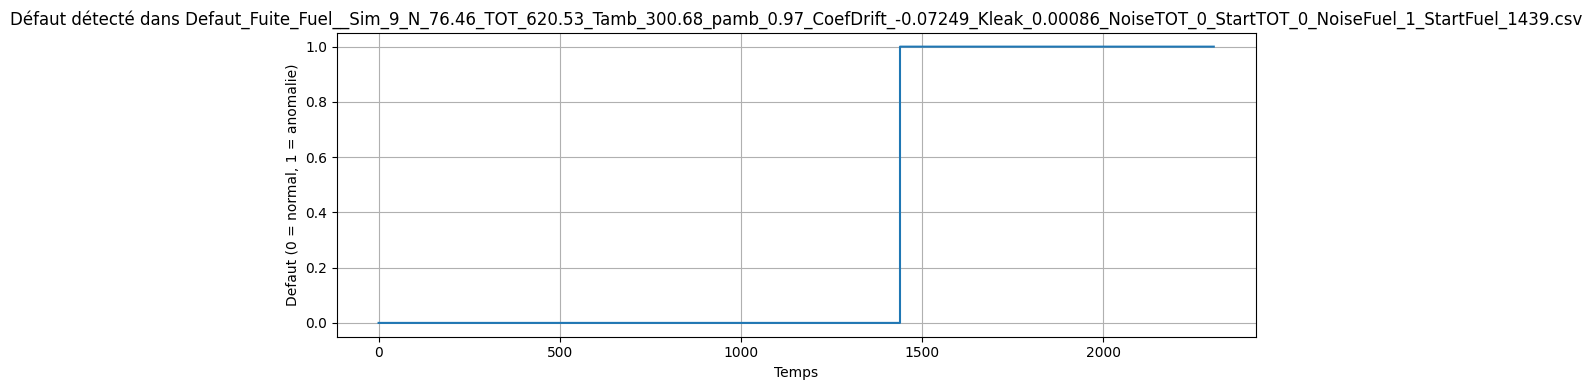

In [0]:
plt.figure(figsize=(10, 4))
plt.plot(df_test["Time"], df_test["Defaut"], drawstyle="steps-post")
plt.title(f"Défaut détecté dans {fichier_test}")
plt.xlabel("Temps")
plt.ylabel("Defaut (0 = normal, 1 = anomalie)")
plt.grid(True)
plt.tight_layout()
plt.show()


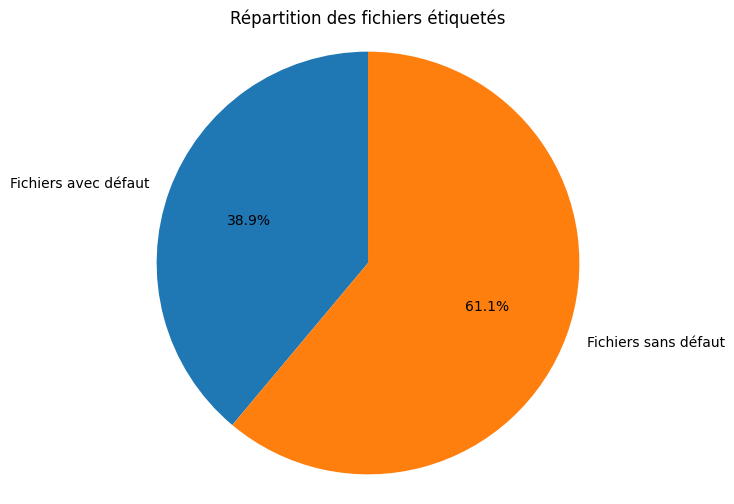

In [0]:
nb_fichiers_avec_defaut = 0
nb_fichiers_sans_defaut = 0

fichiers = [f for f in os.listdir(DOSSIER_SORTIE) if f.endswith(".csv")]
for fichier in fichiers:
    chemin = os.path.join(DOSSIER_SORTIE, fichier)
    try:
        df = pd.read_csv(chemin)
        if "Defaut" in df.columns and df["Defaut"].sum() > 0:
            nb_fichiers_avec_defaut += 1
        else:
            nb_fichiers_sans_defaut += 1
    except Exception:
        continue

labels = ["Fichiers avec défaut", "Fichiers sans défaut"]
sizes = [nb_fichiers_avec_defaut, nb_fichiers_sans_defaut]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des fichiers étiquetés")
plt.axis('equal')
plt.show()


In [0]:
# === VERIFICATION PAR DOSSIER : combien de fichiers avec ou sans défaut ===

from collections import defaultdict

# Dictionnaire : { dossier : [nb_avec_defaut, nb_sans_defaut] }
verif_par_dossier = defaultdict(lambda: [0, 0])

fichiers = [f for f in os.listdir(DOSSIER_SORTIE) if f.endswith(".csv")]

for fichier in fichiers:
    chemin = os.path.join(DOSSIER_SORTIE, fichier)
    try:
        df = pd.read_csv(chemin)
    except:
        continue

    nom_dossier = fichier.split("__")[0]

    if "Defaut" in df.columns and df["Defaut"].sum() > 0:
        verif_par_dossier[nom_dossier][0] += 1  # avec défaut
    else:
        verif_par_dossier[nom_dossier][1] += 1  # sans défaut

# === AFFICHAGE RESULTATS ===
print("\n=== VERIFICATION PAR DOSSIER ===\n")
print(f"{'Dossier':40s} | Avec défaut | Sans défaut | Total")
print("-"*70)

for dossier in ALL_DOSSIERS:
    nb_avec = verif_par_dossier[dossier][0]
    nb_sans = verif_par_dossier[dossier][1]
    total = nb_avec + nb_sans
    print(f"{dossier:40s} | {nb_avec:11d} | {nb_sans:11d} | {total:5d}")

print("\n=== FIN ===")



=== VERIFICATION PAR DOSSIER ===

Dossier                                  | Avec défaut | Sans défaut | Total
----------------------------------------------------------------------
Defaut_CC_T                              |         101 |           0 |   101
Defaut_Compresseur                       |         100 |           0 |   100
Defaut_Fuite_Fuel                        |          99 |           0 |    99
Defaut_Noise_TOT                         |          98 |           0 |    98
Defaut_Rec_T                             |         100 |           0 |   100
Defaut_Recuperateur                      |         100 |           0 |   100
Defaut_Turbine                           |          96 |           0 |    96
FiltreAir                                |           0 |         100 |   100
Defaut_Mix_Final                         |        1072 |           0 |  1072
Defaut_Tuyaux_cc_t                       |          98 |           0 |    98
Defaut_Tuyaux_comp_rec                   |     

In [0]:
DOSSIERS = [
    "FiltreAir"
]


In [0]:
# === MAPPING DES FAULTS ===
fault_mapping = {
    "Foul": "SF",  # pour FiltreAir
}

In [0]:
def extract_active_start(filename, dossier):
    starts = []

    # Cas spécial FiltreAir (corrige ton bug)
    if dossier == "FiltreAir":
        bool_match = re.search(r"Foul_(\d)", filename)
        if bool_match and bool_match.group(1) == "1":
            start_match = re.search(r"SF_(\d+)", filename)
            if start_match:
                starts.append(int(start_match.group(1)))
        return min(starts) if starts else None

    # Cas spécial Defaut_Recuperateur (même cause)
    if dossier == "Defaut_Recuperateur":
        bool_match = re.search(r"Foul_(\d)", filename)
        if bool_match and bool_match.group(1) == "1":
            start_match = re.search(r"SFR_(\d+)", filename)
            if start_match:
                starts.append(int(start_match.group(1)))
        return min(starts) if starts else None

    # Cas classique
    if dossier not in ["Defaut_Mix_Final"]:
        for bool_key, start_key in fault_mapping.items():
            bool_match = re.search(f"{bool_key}_(\d)", filename)
            if bool_match and bool_match.group(1) == "1":
                start_match = re.search(f"{start_key}_?(\d+)", filename)
                if start_match:
                    starts.append(int(start_match.group(1)))

        # Cas Tuyaux
        fuite_bool_match = re.search(r"boolFuites_(\d)_(\d)_(\d)_(\d)", filename)
        fuite_start_match = re.search(r"startFuites_(\d+)_(\d+)_(\d+)_(\d+)", filename)
        if fuite_bool_match and fuite_start_match:
            bools = list(map(int, fuite_bool_match.groups()))
            starts_all = list(map(int, fuite_start_match.groups()))
            starts += [s for b, s in zip(bools, starts_all) if b == 1]

    # Cas Mix
    elif dossier == "Defaut_Mix_Final":
        s_matches = re.findall(r"S[A-Z]+_(\d+)", filename)
        s_values = [int(val) for val in s_matches if int(val) > 0]
        if s_values:
            starts.append(min(s_values))

    return min(starts) if starts else None


<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
/root/.ipykernel/4803/command-5220245770668736-477991936:25: SyntaxWarning: invalid escape sequence '\d'
  bool_match = re.search(f"{bool_key}_(\d)", filename)
/root/.ipykernel/4803/command-5220245770668736-477991936:27: SyntaxWarning: invalid escape sequence '\d'
  start_match = re.search(f"{start_key}_?(\d+)", filename)


In [0]:
# === Fonction de traitement d’un dossier ===
def traiter_dossier(dossier, avec_defaut=True):
    dossier_complet = os.path.join(BASE_DIR, dossier)
    fichiers = [f for f in os.listdir(dossier_complet) if f.endswith(".csv")]

    for fichier in fichiers:
        chemin_fichier = os.path.join(dossier_complet, fichier)
        try:
            df = pd.read_csv(chemin_fichier)
        except Exception as e:
            print(f"[ERREUR LECTURE] {fichier} : {e}")
            continue

        df["Defaut"] = 0

        if avec_defaut:
            start_defaut = extract_active_start(fichier, dossier)
            if start_defaut is not None:
                df.loc[df["Time"] >= start_defaut, "Defaut"] = 1

        nom_sortie = f"{dossier}__{fichier}"
        chemin_sortie = os.path.join(DOSSIER_SORTIE, nom_sortie)

        try:
            df.to_csv(chemin_sortie, index=False)
            statut = "avec défaut" if df["Defaut"].sum() > 0 else "sans défaut"
            print(f"[OK] {nom_sortie} : {statut}")
        except Exception as e:
            print(f"[ERREUR SAUVEGARDE] {nom_sortie} : {e}")

In [0]:
print("\n=== Traitement des dossiers avec défauts ===")
for dossier_defaut in DOSSIERS :
    traiter_dossier(dossier_defaut, avec_defaut=True)

print("\n Tous les fichiers ont été étiquetés et enregistrés dans :", DOSSIER_SORTIE)


=== Traitement des dossiers avec défauts ===
[OK] FiltreAir__Sim_100_N_89.4507_TOT_612.3723_Tamb_272.3597_pamb_0.94_percAsh_0.0001007_Foul_1_SF_425.csv : avec défaut
[OK] FiltreAir__Sim_10_N_63.0342_TOT_510.7900_Tamb_289.6899_pamb_1.02_percAsh_0.0001004_Foul_1_SF_1138.csv : avec défaut
[OK] FiltreAir__Sim_11_N_78.7756_TOT_502.3804_Tamb_280.0061_pamb_1.01_percAsh_0.0001149_Foul_1_SF_1057.csv : avec défaut
[OK] FiltreAir__Sim_12_N_66.6259_TOT_620.3964_Tamb_276.2986_pamb_0.99_percAsh_0.0001499_Foul_1_SF_901.csv : avec défaut
[OK] FiltreAir__Sim_13_N_63.3529_TOT_545.7954_Tamb_308.8169_pamb_1.01_percAsh_0.0001331_Foul_1_SF_1993.csv : avec défaut
[OK] FiltreAir__Sim_14_N_63.1270_TOT_588.5357_Tamb_268.4826_pamb_0.90_percAsh_0.0001520_Foul_1_SF_1635.csv : avec défaut
[OK] FiltreAir__Sim_15_N_94.7478_TOT_516.8872_Tamb_283.1391_pamb_1.01_percAsh_0.0001245_Foul_1_SF_1822.csv : avec défaut
[OK] FiltreAir__Sim_16_N_67.2739_TOT_552.7606_Tamb_270.4269_pamb_1.02_percAsh_0.0001364_Foul_1_SF_1100.csv :